Classification of images that contain deforestation

Deforestatin related tags.
Not great but not bad, these tags where chosen due to lack of temporal satelite data access. 
The deforestation detection problem can  therefore be extended to detecting environments in any satelite image.

In [1]:

TAGS = [
    "agriculture",
    "artisinal_mine",
    "bare_ground",
    "blooming",
    "blow_down",
    "clear",
    "cloudy",
    "conventional_mine",
    "cultivation",
    "habitation",
    "haze",
    "partly_cloudy",
    "primary",
    "road",
    "selective_logging",
    "slash_burn",
    "water",
]

DEFORESTATION_TAGS = [
    "agriculture",
    "artisinal_mine",
    "conventional_mine",
    "cultivation",
    "road",
    "selective_logging",
    "slash_burn",
]

In [2]:
# necessary for using the google collab together with the amazon rainforest dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

In [4]:
# train data is labeled inside a .csv file

df_train = pd.read_csv('./drive/MyDrive/ML_DATA/amazon/train_v2.csv')
df_train.sample(5)

,image_name,tags
3740,train_3740,haze primary
167,train_167,agriculture habitation partly_cloudy primary road
1070,train_1070,cloudy
1291,train_1291,partly_cloudy primary
3727,train_3727,agriculture clear habitation primary road


Dataset classes exploration

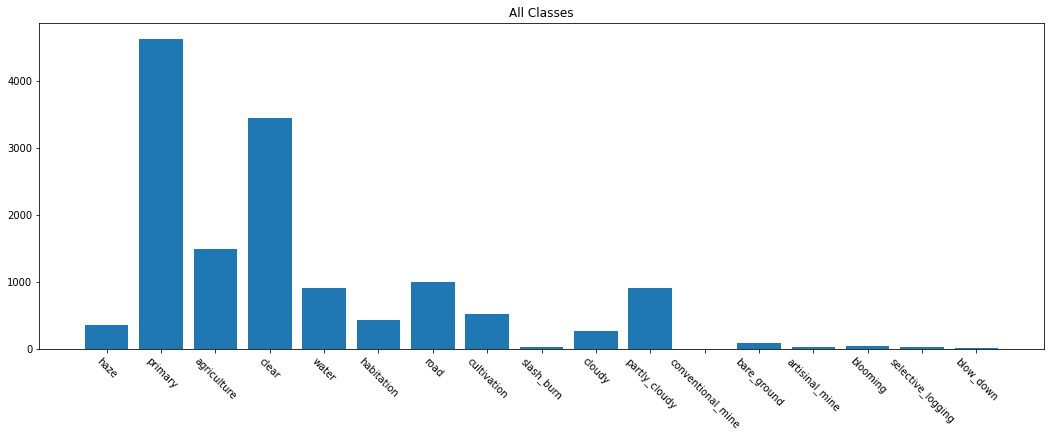

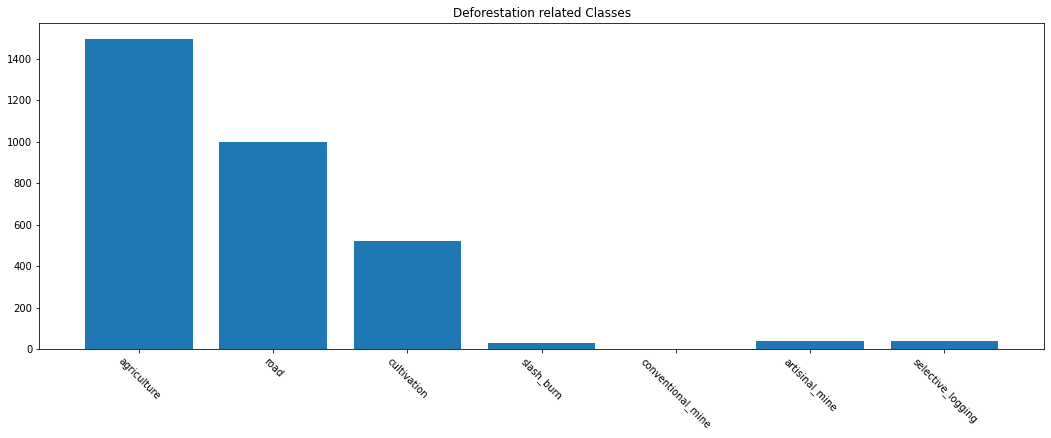

In [5]:
# Total number of tags and their names.
counts = {}
counts_deforestation_related = {}

splitted_tags = df_train['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0
        if label in DEFORESTATION_TAGS:
          counts_deforestation_related[label] = counts_deforestation_related[label] + 1  if label in counts_deforestation_related else 0


plt.figure(figsize=(18, 6))
plt.title('All Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

plt.figure(figsize=(18, 6))
plt.title('Deforestation related Classes')
idxs = range(len(counts_deforestation_related.values()))
plt.xticks(idxs, counts_deforestation_related.keys(), rotation=-45)
plt.bar(idxs, counts_deforestation_related.values());

train_172
train_173
train_174


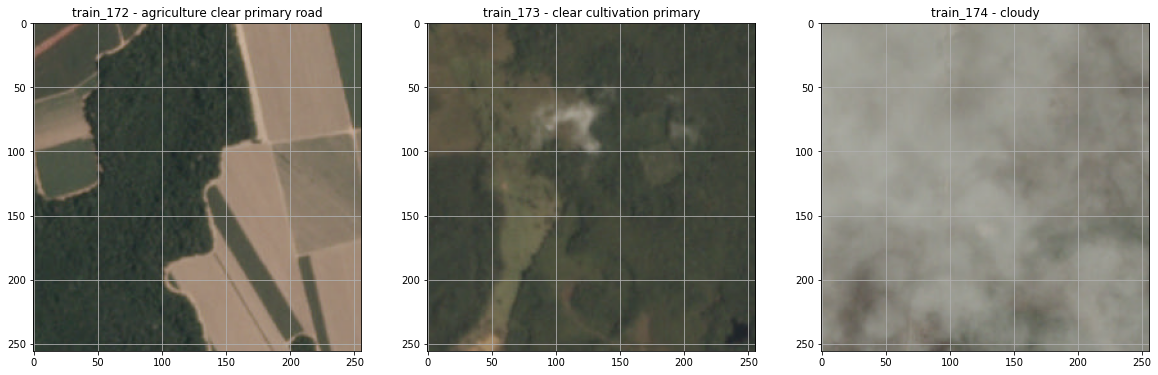

In [6]:
# display 3 random images from the dataset

plt.rc('axes', grid = True)

_, ax = plt.subplots(1, 3, figsize=(20, 20))
random_img = np.random.randint(0, len(df_train) - 3)

for i , (file, label) in enumerate(df_train[random_img:random_img + 3].values):
    print (file)
    img = cv2.imread('./drive/MyDrive/ML_DATA/amazon/data/train-jpg/{}.jpg'.format(file))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('{} - {}'.format(file, label))
    
plt.show()

In [7]:
# Load data

all_labels = TAGS
labels = list(set([y for x in all_labels for y in x]))

def load_data(df_train, labels, resize):
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in df_train.values:
        img = cv2.imread('./drive/MyDrive/ML_DATA/amazon/data/train-jpg/{}.jpg'.format(f))

        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        # scale image to desired dimensions
        X_train.append(cv2.resize(img, resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    # normalize the images
    X_train = np.array(X_train, np.float16) / 255.

    return X_train, y_train

In [8]:
X, y = load_data(df_train, TAGS, resize=(128, 128))

In [15]:
# split using a 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = int(time.time()))

In [10]:
# Defining a function to plot our learning curve

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# Function to calculate the F Beta Score (F2).
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [43]:
optimizer = Adam(0.001, decay=0.0005)
base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = True
    

model = Sequential([
    base_model,
    
    Flatten(), 
        
    Dense(128, activation='relu'),

    Dropout(0.2),

    Dense(128, activation='relu'),

    Dropout(0.2),

    Dense(17, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_27 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               33024     
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 17)               

In [44]:
model_fit = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    verbose=1,
    validation_data=(X_val, y_val),
    shuffle=True)

Epoch 1/50
25/25 [==============================] - 9s 172ms/step - loss: 0.9502 - fbeta_score_K: 0.5056 - val_loss: 0.4680 - val_fbeta_score_K: 0.4333
Epoch 2/50
25/25 [==============================] - 3s 130ms/step - loss: 0.3668 - fbeta_score_K: 0.5302 - val_loss: 0.3419 - val_fbeta_score_K: 0.4977
Epoch 3/50
25/25 [==============================] - 3s 131ms/step - loss: 0.3159 - fbeta_score_K: 0.5419 - val_loss: 0.2701 - val_fbeta_score_K: 0.5659
Epoch 4/50
25/25 [==============================] - 3s 134ms/step - loss: 0.2804 - fbeta_score_K: 0.5647 - val_loss: 0.2682 - val_fbeta_score_K: 0.5634
Epoch 5/50
25/25 [==============================] - 3s 135ms/step - loss: 0.2695 - fbeta_score_K: 0.5712 - val_loss: 0.2799 - val_fbeta_score_K: 0.5411
Epoch 6/50
25/25 [==============================] - 3s 132ms/step - loss: 0.2776 - fbeta_score_K: 0.5783 - val_loss: 0.2446 - val_fbeta_score_K: 0.5915
Epoch 7/50
25/25 [==============================] - 3s 132ms/step - loss: 0.2587 - fbeta

In [45]:
y_pred = model.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100 - score * 100))

2/2 [==============================] - 2s 154ms/step
F beta score:  0.7480530549200205
Error: 25.19%


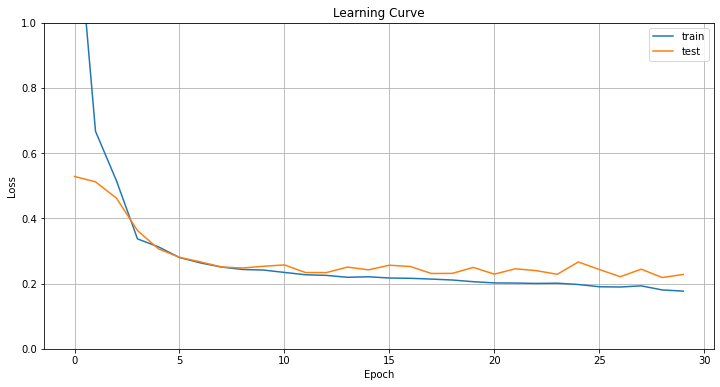

In [27]:
learning_curve(model_fit, key='loss', ylim=(0, 1))